# ASTR Final Project - Aaron Kosoff

In this project I will map all the data

In [2]:
import numpy as np
import sep
import os

In [3]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [4]:
#fits_start = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\'
hdu1 = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
hdu2 = 'min_jw02731-o001_t017_nircam_clear-f187n_i2d.fits'
hdu3 = 'min_jw02731-o001_t017_nircam_clear-f200w_i2d.fits'
hdu4 = 'min_jw02731-o001_t017_nircam_clear-f335m_i2d.fits'
hdu5 = 'min_jw02731-o001_t017_nircam_clear-f444w_i2d.fits'
hdu6 = 'min_jw02731-o001_t017_nircam_f444w-f470n_i2d.fits'

In [5]:
#Here we use fopen to access all the information by the specified file location
hdulist = fits.open(hdu1)
data = hdulist[0].data

# Copies data to a new array, preserves the ordering of the original array
new_data = data.astype(data.dtype.newbyteorder("="))
# The same outcome as the previous operation
new_data = data.byteswap()
new_data = new_data.view(new_data.dtype.newbyteorder("="))
# Changes data in-place
data = data.byteswap()
data = data.view(data.dtype.newbyteorder("="))

In [6]:
print(np.shape(data))
print(data[0:5,0:5])

(8582, 14339)
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


#### UH OH! We got NaNs! Time to scrap some code to deal with this from lecture 18!

In [7]:
def rescale_image(data,vmin=0.5,vmax=100):
    # copy the data to avoid accidentaly overwriting it
    data_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    m = np.nanmean(data_tmp)

    # any data points below vpmin is assigned the value vpmin
    # any data points above vpmax is assigned the value vpmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace all NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # apply log-scale
    data_tmp = np.log10(data_tmp)
    return data_tmp

In [8]:
rescaled_data = rescale_image(data,vmin=0.5,vmax=100)

12.822664
1.6756457


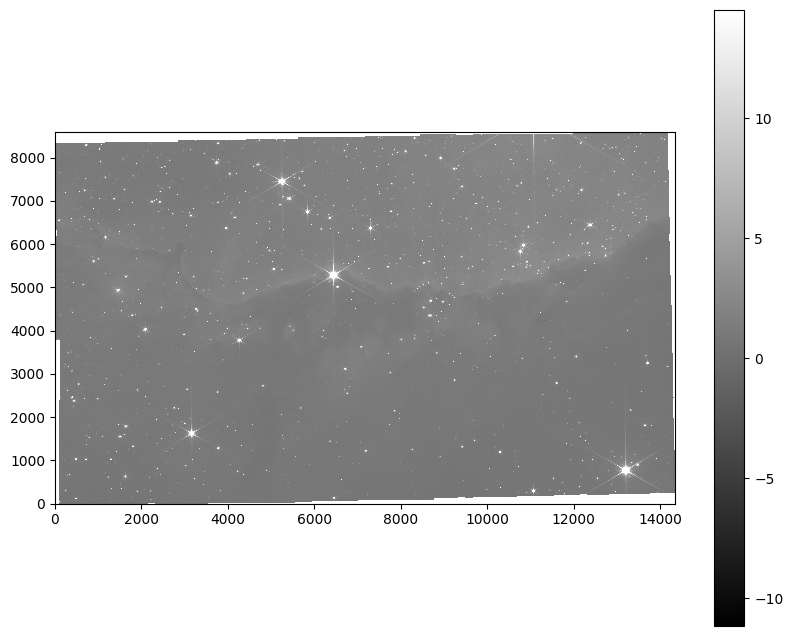

In [9]:
# show the image

m, s = np.nanmean(data), np.nanstd(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
print(s)
print(m)

In [10]:
mask = np.isnan(data)  # True where data is NaN

In [11]:
# measure a spatially varying background on the image
#bkg = sep.Background(data)
bkg = sep.Background(data, mask=mask)
#bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

In [12]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1997147798538208
0.06582547724246979


In [13]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

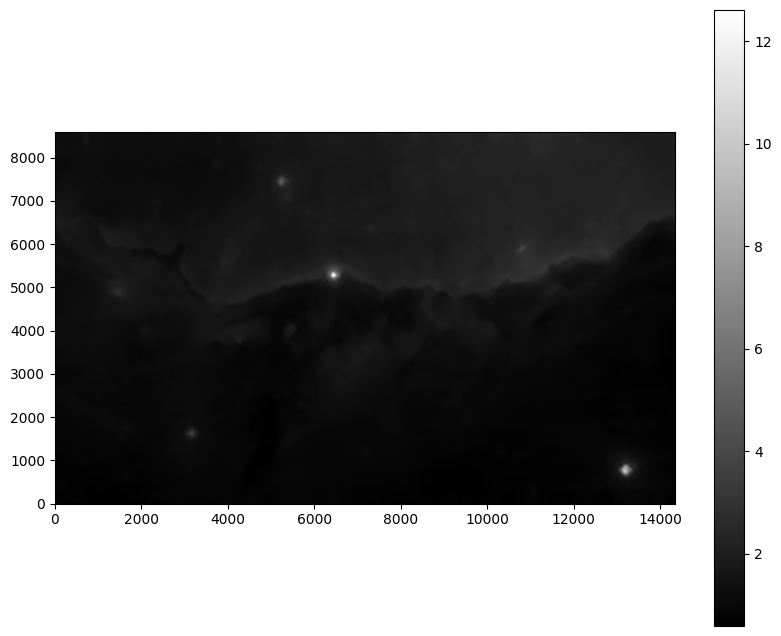

In [14]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save the figure
plt.savefig(hdu1+'bkg_image.png', bbox_inches = 'tight', facecolor = "white")

In [15]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()
bkg_rms = data - bkg.back()

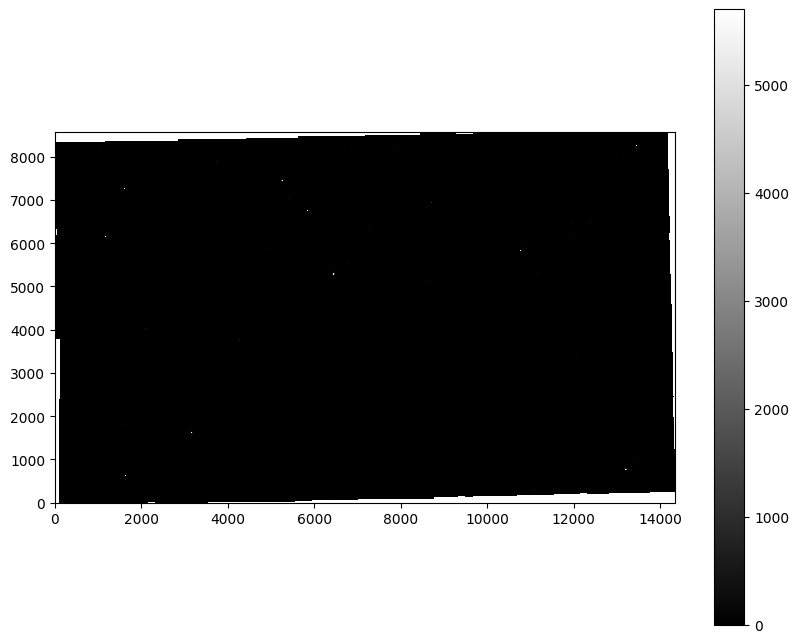

In [16]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save the figure
plt.savefig(hdu1+'bkg_rms.png', bbox_inches = 'tight', facecolor = "white")

In [17]:
# subtract the background
data_sub = data - bkg.back()

#### Here we define the detection threshold to be a constant value of 10$\sigma$ where $\sigma$ is the global background RMS

In [18]:
objects = sep.extract(data_sub, 10, err=bkg.globalrms, mask=mask)
print(len(objects))

11958


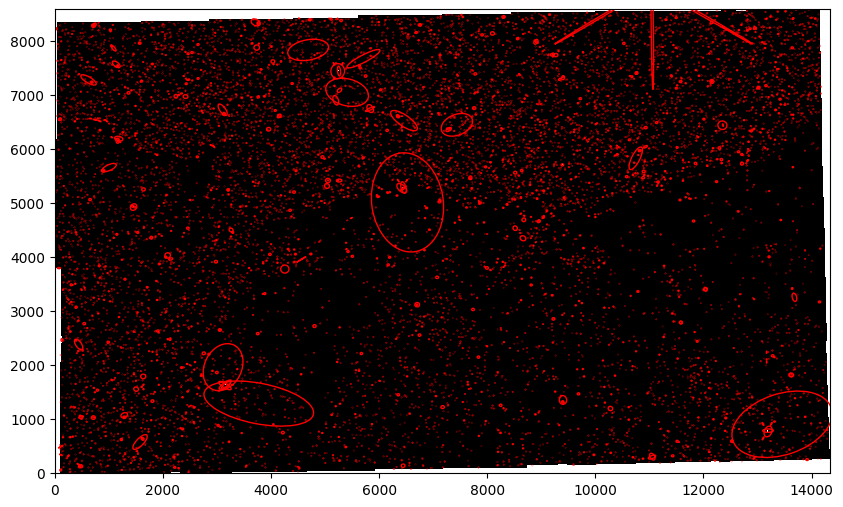

In [19]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

#save the figure
plt.savefig(hdu1+'objects.png', bbox_inches = 'tight', facecolor = "white")

In [20]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

#### Here, we calculate the flux of each of these objects to observe the given data

In [21]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0, mask=mask)

no_nan_flux = flux[np.isfinite(flux)] #We call this line so that we can properly map the fluxes onto a histogram

# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 36.589886 +/- 6.059121
object 1: flux = 11.585197 +/- 3.421581
object 2: flux = 249.575570 +/- 15.801828
object 3: flux = 36.325957 +/- 6.037201
object 4: flux = 474.404164 +/- 21.783642
object 5: flux = 15.155003 +/- 3.908605
object 6: flux = 56.966824 +/- 7.555762
object 7: flux = 19.046619 +/- 4.378220
object 8: flux = 80.441002 +/- 8.975719
object 9: flux = 21.400567 +/- 4.639337


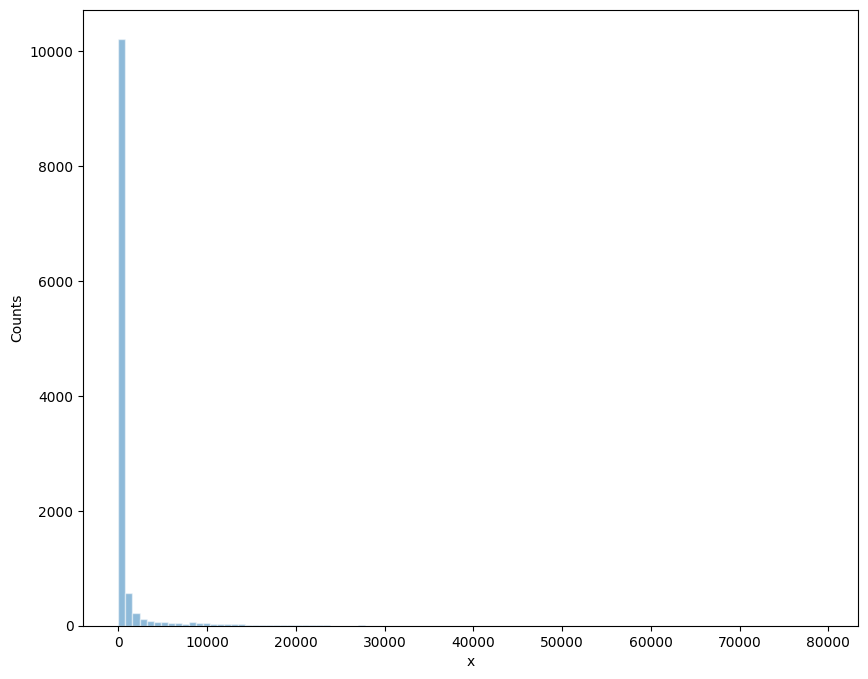

<Figure size 1000x800 with 0 Axes>

In [22]:
# create the histogram
plt.hist(no_nan_flux, bins=100, alpha = 0.5, edgecolor='white')
#plt.hist(data, bins=10, alpha = 0.5, edgecolor='black')
plt.xlabel('x')
plt.ylabel('Counts')
plt.show()

#save the figure
plt.savefig(hdu1+'object_flux.png', bbox_inches = 'tight', facecolor = "white")

#### Here we print out all information in regards to the f090w fluxes

What are the mean, median, and standard deviation of the distribution of fluxes. What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean

In [23]:
vmin = np.percentile(no_nan_flux, 5) #Clip at the 5th percentile to avoid noise
vmax = np.percentile(no_nan_flux, 80) #Clip at the 80th percentile to avoid noise

cflux = flux.copy()

fmean = np.mean(cflux)

vpmin = vmin * fmean
vpmax = vmax * fmean

#Here we account for any noise by overwriting anything out of our respective percentile
cflux[cflux<vpmin] = vpmin
cflux[cflux>vpmax] = vpmax

#Here we actually overwrite the NaNs
cflux = np.nan_to_num(cflux, nan = vpmin)

In [24]:
print(f"No NaN Flux: {no_nan_flux}")
print(f"Flux Mean: {np.mean(no_nan_flux)}")
print(f"Flux Median: {np.median(no_nan_flux)}")
print(f"Flux Standard Deviation: {np.std(no_nan_flux)}")

No NaN Flux: [3.65898857e+01 1.15851968e+01 2.49575570e+02 ... 2.24277327e+04
 9.33424091e+01 3.10567388e+01]
Flux Mean: 971.2133749976259
Flux Median: 59.611632292270656
Flux Standard Deviation: 3572.3181495025606


#### Now... to find the largest outlier, we look towards the guidance of the Chauvenet Criterion

In [25]:
from scipy.special import erf # importing the error function from scipy

In [26]:
def event_probability(x, mu=0.0, s=1.0):
    #x is the value of the event
    #mu is the gaussian mean (default 0.0)
    #s is the gaussian std dev (default 1.0)

    #z is how many sigma away x is from the mean
    z = np.fabs((x-mu)/s)

    #the error "erf" is the primitive (or anti-derivative) of
    #the gaussian function, its value is directly related
    #to the area under the gaussian curve, and therefore probabilities
    return 1.0 - (erf(z/np.sqrt(2)))

In [27]:
def chauvenet_criterion(prior_measurements, outlier):
    #prior_measurements is our set of previous measurements
    #outlier is the value we want to check

    #return True if the outlier can be discarded
    #return False if the outlier cannot be immediately discarded

    #compute the mean and std of prior measurements
    #and assume these are representative of the gaussian
    mean = np.mean(prior_measurements)
    std = np.std(prior_measurements)

    #compute the probability of the outlier
    outlier_probability = event_probability(outlier, mu=mean, s=std)

    #get number of events, including the outlier
    N = len(prior_measurements) + 1

    #check Chauvenet's criterion
    if N * outlier_probability < 0.5:
        #reject the outlier
        return True

    #if we are here, that means the above condition was False
    #we cannot discard the outlier
    return False

#### Here I apply step 8

In [28]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f187n_i2d.fits'
fname2 = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f200w_i2d.fits'
fname3 = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f335m_i2d.fits'
fname4 = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f444w_i2d.fits'
fname5 = r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_f444w-f470n_i2d.fits'

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

Set DATE-AVG to '2022-06-03T12:17:28.687' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.567170 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654335564.228 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-03T11:43:37.007' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.631' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.557313 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654186065.609 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f187n_i2d.fits -> C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.326' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574431 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654445751.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f200w_i2d.fits -> C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]


Reprojected C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f335m_i2d.fits -> C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]


Reprojected C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f444w_i2d.fits -> C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T11:43:37.025' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.695' from MJD-END'. [astropy.wcs.wcs]


Reprojected C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_f444w-f470n_i2d.fits -> C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits


In [29]:
#Here we apply the projections to then reopen them and FINALLY color them!!
refiles = [r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits',
          r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits',
          r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits',
          r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits',
          r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits']

fits.open(r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits')

hdu = fits.open(r'C:\Users\athek\OneDrive\Desktop\School_Stuff\ASTR19-Programs\minimized_fits\min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits')
original = hdu['SCI'].data

images = [original]
for f in refiles:
    hdu = fits.open(f)
    images.append(hdu['PRIMARY'].data)

In [30]:
def remap(data):
    #copy the data to avoid accidently overwriting it
    data_tmp = data.copy()

    dmin = data_tmp.min()
    dmax = data_tmp.max()
    return (data_tmp - dmin)/(dmax-dmin)

In [31]:
remap_images = []

#for f in refiles:
#    with fits.open(f) as hdul:
#        img_data = hdul['PRIMARY'].data
#        remap_images.append(remap(img_data))

for f in refiles:
    with fits.open(f) as hdul:
        img_data = hdul['PRIMARY'].data

        # 1. Rescale first (optional: set vmin/vmax globally or per-layer)
        rescaled = rescale_image(img_data, vmin=0.01)  # or pick smarter values

        # 2. Remap (normalize)
        normalized = remap(rescaled)  # your existing remap function

        remap_images.append(normalized)

data_all = np.zeros((remap_images[0].shape[0], remap_images[0].shape[1], 3))

#F090W is BLUE
#F187N is CYAN
#F200W is GREEN
#F470N is YELLOW
#F335M is ORANGE
#F444W is RED

data_all[:, :, 0] = remap_images[4]   # Red = F444W
data_all[:, :, 1] = remap_images[3]   # Green = F335M
data_all[:, :, 2] = remap_images[2]   # Blue = F200W

data_all_res = rescale_image(data_all, vmin=0.01)

C:\Users\athek\AppData\Local\Temp\ipykernel_3420\2927011180.py:6: RuntimeWarning: Mean of empty slice
  m = np.nanmean(data_tmp)


ValueError: x and y can be no greater than 2D, but have shapes (5,) and (5, 8582, 14339)

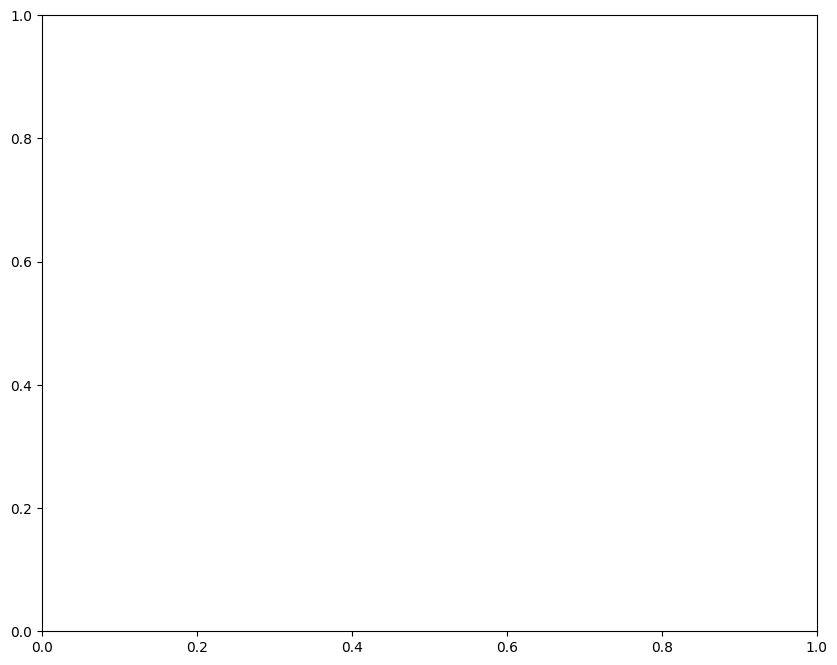

In [32]:
plt.plot(remap_images)